<a href="https://colab.research.google.com/github/spretosg/PAREUS_project/blob/main/SK021_agri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select most optimal areas within agricultural areas

The gap analysis for the protected areas (PA) in Trnava region (SK021) revealed that only between 2% and 15% of the agricultural areas (LULC class 200-250) is covered by the current network of PA. Thus, agricultural areas in the Trnava region serves a considerable potential for OECM development, safeguarding agricultural production and simultaneously conserve areas of high ES conditions and ecosystem services.

The following script will therefore setup a spatial optimization problem tailored for the agricultural areas in Trnava region.

## Packages and data preparation
*(Call the following junck of code just once in the runtime)*

In [1]:
!pip install folium
!pip install geopandas
!pip install pymoo

#imports
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point # Polygon was imported correctly
import folium
import sys
import multiprocessing
import os

#optim package pymoo
#!pip install pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from shapely.ops import unary_union
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx  import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation # Import BitflipMutation
from pymoo.core.callback import Callback
from pymoo.indicators.hv import HV

## optimization follows here:
from pymoo.termination import get_termination
import pandas as pd
import matplotlib.pyplot as plt
from pickle import TRUE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 134.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 20.8 MB/s eta 0:00

### Load data
The input data for the optimization is in *.json* format. It represents a regular grid of planning units (PU). Each planning unit contains several values sampled from raster data *(check script prep_data_optim_singleHabitat.R)*. The data is stored on a google drive bucket.

In [2]:
GCP_PROJECT_ID = 'pareus'
PROJECT_NUMBER = '863990074236 '


if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

BUCKET_NAME = 'colab_optim'

GCS_BUCKET = f'gs://{BUCKET_NAME}'
!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET
!gcloud storage cp gs://colab_optim/SK021_agri.json .

Creating gs://colab_optim/...
ServiceException: 409 A Cloud Storage bucket named 'colab_optim' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying gs://colab_optim/SK021_agri.json to file://./SK021_agri.json

Average throughput: 230.5MiB/s


In [3]:
grid_gdf = gpd.read_file("SK021_agri.json")

## Grid overview

TypeError: Legend.__init__() got an unexpected keyword argument 'label'

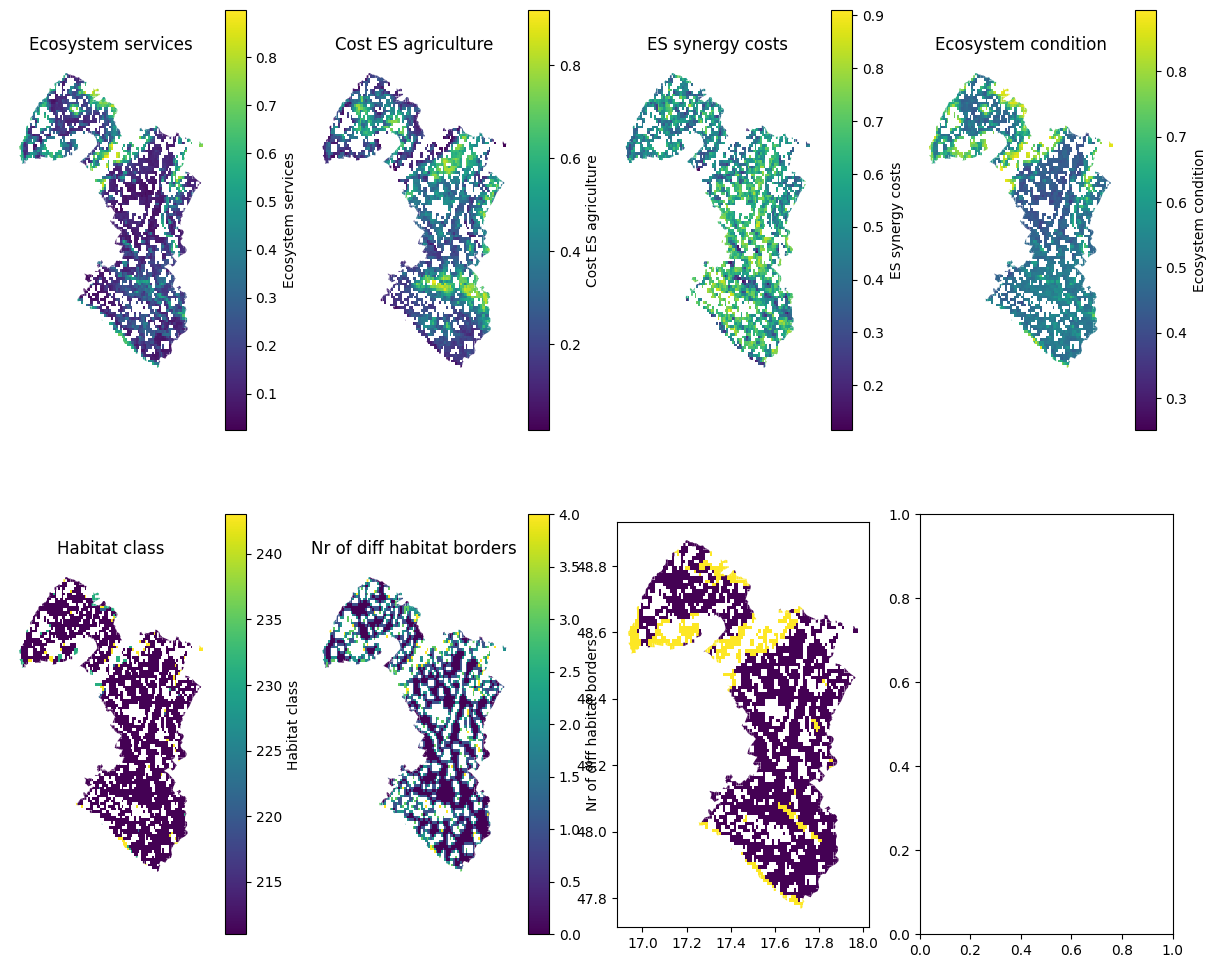

In [ ]:
variables = ['es_service', 'cost_agri_es','cost_es_synergy', 'es_condition', 'habitat','habitat_border_count', 'in_pa']
titles = ['Ecosystem services','Cost ES agriculture', 'ES synergy costs', 'Ecosystem condition','Habitat class', 'Nr of diff habitat borders', 'inside protected area']

# Set up a 2x2 grid for four subplots (adjust if you have more or fewer variables)
fig, axes = plt.subplots(2, 4, figsize=(15, 12))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, var in enumerate(variables):
    grid_gdf.plot(column=var,
             cmap='viridis',               # Color map (adjust as needed)
             legend=True,                   # Add a legend
             legend_kwds={'label': titles[i]},  # Label legend based on variable
             ax=axes[i])                    # Specify the subplot for this variable
    axes[i].set_title(titles[i])            # Set title for each subplot
    axes[i].set_axis_off()                  # Hide axes for a cleaner map

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optimization

## Parameter settings
To run the spatial optimization several parameters:


*   Weights for each optimization goals [0,1]
*   Relative area to be covered by the solutions (e.g. 10% from all agricultural areas)
*   If connectivity of the PU's should be enhanced (T/F)
*   Number of iterations of the optimization
*   If PU's within the current PA's should be included or not in the optimization (might need to adjust the relative area of protection)





In [4]:
# agri settings

w_es_benefit = 1 #importance to maximize es benefits
w_es_cond = 1 #importance to maximize es condition
w_cost = 1 ## importance of minimizing the costs (select one of several cost layers)
w_con = 1 #importance of connectivity
w_border = 1 #importance of maximizing multiborder patches
min_fraction=0.13 # fraction to be covered
max_fraction = 0.18

## lock out (should already protected areas be included in the optimization?)
include_wdpa = False # True if PU's in current PA should be inluded (True) or not (False) -- may reconsider min_fraction

# area restrictions what is the minimal and maximal area that the optimized solutions should cover?

## should connectivity be inluded
connectivity = False # False if connectivity is not considered

## how many iterations?
n_iter = 30000

## subset the grid_gdf input regarding PU's in PA
if include_wdpa == False:
  grid_gdf = grid_gdf[grid_gdf['in_pa'] == include_wdpa]

## assign the area km2 for each PU ()
grid_gdf_projected = grid_gdf.to_crs('EPSG:3035')
grid_gdf['area'] = grid_gdf_projected.geometry.area/1000000
print(grid_gdf['area'])

## drop possible NaN (e.g. offshore in this case)
grid_gdf = grid_gdf.dropna()

11      0.833030
17      0.832871
18      0.832871
19      0.832871
20      0.575400
          ...   
3522    0.028241
3523    0.627788
3524    0.448264
3525    0.187249
3526    0.073334
Name: area, Length: 3011, dtype: float64


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Problem formulation
In pymoo a class of Problem needs to be defined for the optimization problem. Two different problems will be defined and later called dependent on the input parameter of connectivity.

### Problem without connectivity
This problem is a 4 objective problem


1.   Maximizing ES benefit of the PU's
2.   Maximizing ES condition of the PU's
3.   Minimizing cost layer (to be defined if based on policy, synergy or es agricultural) *currently costs are defined as the es benefits from agriculture -- assuming areas of high agricultural productivity are more difficult to change into OECM)*
4.   Maximizing the number of borders with other landsca types than agricultural areas --> border habitats

The problem is constrained with a min and a max fraction of the total habitat area which should be selected in the optimization. Solutions outside this band are not considered.



In [5]:
class SpatOpt_agri(Problem):
    def __init__(self, grid_gdf, min_fraction, max_fraction, w1, w2, w3, w4, n_obj=4):
        super().__init__(n_var=len(grid_gdf),
                         n_obj=n_obj,
                         n_ieq_constr=2,  # now two constraints
                         xl=0,
                         xu=1,
                         type_var=int)

        self.features = grid_gdf.reset_index(drop=True)
        self.area = self.features['area'].values
        self.total_area = self.area.sum()
        self.min_total_area = self.total_area * min_fraction
        self.max_total_area = self.total_area * max_fraction
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.atleast_2d(x)

        es_service = self.features['es_service'].values
        es_condition = self.features['es_condition'].values
        cost = self.features['cost_agri_es'].values
        habitat_border_count = self.features['habitat_border_count'].values
        area = self.area

        # Objectives
        f1 = self.w1 * -np.sum(x * es_service, axis=1)               # max ES
        f2 = self.w2 * -np.sum(x * es_condition, axis=1)             # max condition
        f3 = self.w3 * np.sum(x * cost, axis=1)                      # min cost
        f4 = self.w4 * -np.sum(x * habitat_border_count, axis=1)    # max edge diversity
        out["F"] = np.column_stack([f1, f2, f3, f4])

        # Constraints: total selected area between min and max
        total_selected_area = np.sum(x * area, axis=1)
        g1 = self.min_total_area - total_selected_area   # ≤ 0 when min met
        g2 = total_selected_area - self.max_total_area   # ≤ 0 when max not exceeded

        out["G"] = np.column_stack([g1, g2])

### Problem including connectivity
This problem is an extension of the first problem. The same goals and constraints but in addition maximize connectivity of the selected PU's as a 5th goal.

In [ ]:
class SpatOptagri_con(Problem):
    def __init__(self, grid_gdf, min_fraction, max_fraction, w1, w2, w3, w4, w5, n_obj=5):
        super().__init__(n_var=len(grid_gdf),
                         n_obj=n_obj,
                         n_ieq_constr=2,
                         xl=0,
                         xu=1,
                         type_var=int)
        self.features = grid_gdf.reset_index(drop=True)
        self.area = self.features['area'].values
        self.total_area = self.area.sum()
        self.min_total_area = self.total_area * min_fraction
        self.max_total_area = self.total_area * max_fraction
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5

        # Precompute adjacency matrix based on geometry overlap or proximity
        self.adjacency_matrix = self.compute_adjacency_matrix(grid_gdf)

    def compute_adjacency_matrix(self, grid_gdf):
        """
        Computes a binary adjacency matrix based on proximity of grid cells.
        """
        n = len(grid_gdf)
        adjacency_matrix = np.zeros((n, n), dtype=int)

        # Build spatial index for faster neighbor search
        for i, geom1 in enumerate(grid_gdf.geometry):
            for j, geom2 in enumerate(grid_gdf.geometry):
                if i != j and geom1.distance(geom2) < 1e-3:  # threshold distance for adjacency
                    adjacency_matrix[i, j] = 1
                    adjacency_matrix[j, i] = 1
        return csr_matrix(adjacency_matrix)

    def _evaluate(self, x, out, *args, **kwargs):
        es_service = self.features['es_service'].values
        es_condition = self.features['es_condition'].values
        cost = self.features['cost_agri_es'].values
        habitat_border_count = self.features['habitat_border_count'].values
        area = self.area

        f1 = self.w1 * -np.sum(x * es_service, axis=1)               # max ES
        f2 = self.w2 * -np.sum(x * es_condition, axis=1)             # max condition
        f3 = self.w3 * np.sum(x * cost, axis=1)                      # min cost
        f4 = self.w4 * -np.sum(x * habitat_border_count, axis=1)    # max edge diversity

        # Objective 5: Maximize connectivity using adjacency matrix
        f5 = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            selected_units = np.where(x[i] == 1)[0]
            if selected_units.size > 0:
                # Subset the adjacency matrix for the selected units
                sub_adj_matrix = self.adjacency_matrix[selected_units][:, selected_units]

                # Count connected components
                n_components, labels = connected_components(csgraph=sub_adj_matrix, directed=False)
                f5[i] = n_components - 1  # Minimize the number of disconnected components

        # Multiply the connectivity objective by its weight w4
        f5 = self.w5 * f5

        out["F"] = np.column_stack([f1, f2, f3, f4, f5])

        total_selected_area = np.sum(x * area, axis=1)
        g1 = self.min_total_area - total_selected_area   # ≤ 0 when min met
        g2 = total_selected_area - self.max_total_area   # ≤ 0 when max not exceeded

        out["G"] = np.column_stack([g1, g2])

## Call the problem

To run the optimization, the correct problem must be called and initialized with the parameters defined previously.

In [6]:
if connectivity == True:
    n_obj = 5
    problem = SpatOptagri_con(grid_gdf, min_fraction, max_fraction, w_es_benefit,w_es_cond, w_cost, w_border, w_con) ## should be the more optimized version for connectivity
    print("Using connectivity")
else:
    n_obj = 4
    problem = SpatOpt_agri(grid_gdf, min_fraction, max_fraction, w_es_benefit, w_es_cond, w_cost, w_border)

    print("No connectivity used")

No connectivity used


### Algorithm definition
The pproblem could be solved with different multi-objective algorithms. In this case a *non-dominated sorting* NSGA-III algorithm is used. In addition each optimization iteration will track some statistics about the performance of the solution on the defined problem.

In [7]:
ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=12)

algorithm = NSGA3(
    pop_size=len(ref_dirs)+1,
    n_offsprings=10,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),  # Use binary crossover
    mutation=BitflipMutation(),    # Use bitflip mutation
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)

# Callback to track HV
class HVCallback(Callback):
    def __init__(self, ref_point):
        super().__init__()
        self.hv = HV(ref_point=ref_point)
        self.hv_values = []

    def notify(self, algorithm):
        F = algorithm.pop.get("F")
        hv = self.hv.do(F)
        self.hv_values.append(hv)

# Define a reference point for hypervolume calculation according to the number of objectives
if connectivity == True:
    ref_point = np.array([1, 1, 1,1,1])
else:
    ref_point = np.array([2, 2, -1,5])

hv_callback = HVCallback(ref_point)

### Run the algorithm
According to the input parameter n_iter, the NSGA-III will rund n-times. Each time a set of possible solutions will be generated. Optimal solutions will be stored in a list.

In [8]:


termination = get_termination("n_gen", n_iter)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               n_jobs=-1,  # Utilize all available cores
               save_history=True,
               callback=hv_callback,
               verbose=True)


Streaming output truncated to the last 5000 lines.
 25001 |   250456 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0024026163 |             f
 25002 |   250466 |     52 |  0.000000E+00 |  0.000000E+00 |  0.0029270128 |             f
 25003 |   250476 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0039493172 |             f
 25004 |   250486 |     54 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
 25005 |   250496 |     54 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
 25006 |   250506 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0002635677 |             f
 25007 |   250516 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0002635677 |             f
 25008 |   250526 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0002586868 |             f
 25009 |   250536 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0011895921 |             f
 25010 |   250546 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0012120373 |             f
 25011 |   250556 |     51 |  0.000000E

## Evaluation
After the termination of the optimization different statistics can be computed and final spatially optimal solutions delineated.



In [9]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population
hist = res.history # from the results object
for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 6426 after 64716 evaluations.


The Convergence curve shows that after 64000 evaluations, optimal solutions are found and not further improved.

Whole population feasible in Generation 6587 after 66326 evaluations.


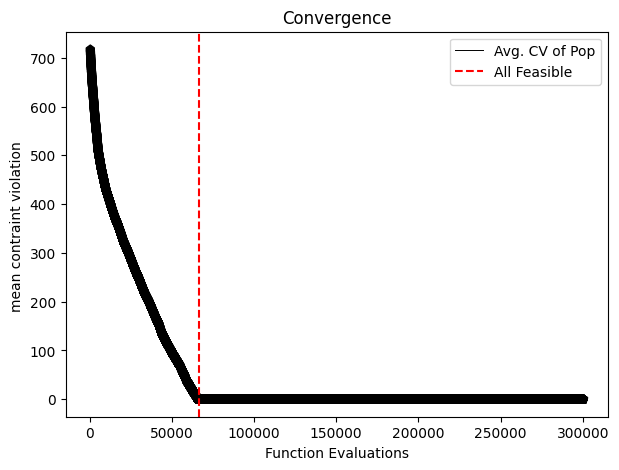

In [10]:
import matplotlib.pyplot as plt
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("mean contraint violation")
plt.legend()
plt.show()

### Hypervolume
The hypervolume indicator, also known as the Lebesgue measure, quantifies the volume of the objective space that is dominated by the set of solutions. A larger hypervolume generally indicates a better set of solutions, as it implies better coverage of the Pareto front and greater diversity

[-165.3530765  -274.88403818  103.14232705 -697.        ]


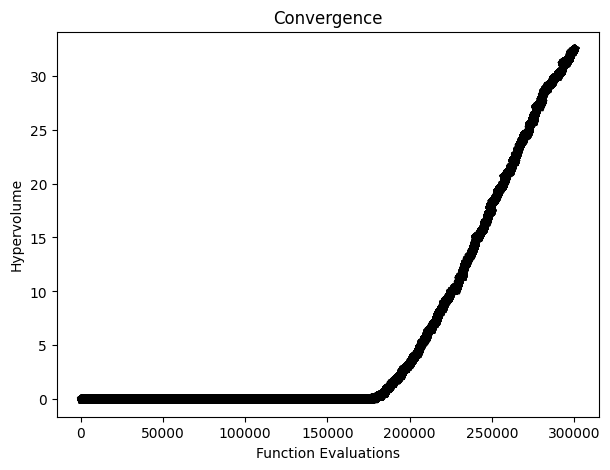

In [18]:
from pymoo.indicators.hv import Hypervolume
F = res.opt.get("F")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

print(approx_nadir)
metric = Hypervolume(ref_point= np.array([2, 2, 2,5]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()


## Optimal PU's
Each PU is selected n-times as part of an optimal solution. Thus, a count for each PU how often it is selected in an optimal solution gives a measure of *importance* for this PU contributing to an optimal solution. This measure is stored as a new attribute in the input data frame.


In [14]:
unit_counts = {}
for i in range(len(grid_gdf)):
    unit_counts[i] = 0

# Iterate through the optimal solutions
for solution in res.X:
    # Get indices of selected units (assuming binary solutions)
    selected_indices = np.where(solution == 1)[0]
    # Increment counts for selected units
    for idx in selected_indices:
        unit_counts[idx] += 1

# Print the counts
#for unit_id, count in unit_counts.items():
#    print(f"Planning Unit {unit_id}: {count} occurrences")

count_series = pd.Series({k: v / len(res.G) for k, v in unit_counts.items()}, name='rel_occ_paropt1')
grid_gdf = grid_gdf.reset_index(drop=True)  # Drop the old index
grid_gdf = grid_gdf.join(count_series)

Display the important PU's on a map with a given threshold value of importance

In [15]:
import folium

# Define the color map
color_map = 'YlGn'

# Set the threshold
threshold = 0.5  # Replace with your desired threshold value

# Filter the GeoDataFrame
filtered_gdf = grid_gdf[grid_gdf['rel_occ_paropt1'] >= threshold]


# Total area
total_area = grid_gdf['area'].sum()

# Area where rel_occ_paropt1 > threshold
filtered_area = filtered_gdf['area'].sum()

# Relative area covered
relative_coverage = filtered_area / total_area

print(f"Relative area covered with high important areas outside PA {threshold}: {relative_coverage:.4f}")



# Create a new column for the color values
filtered_gdf['color_value'] = filtered_gdf['rel_occ_paropt1']

# Create a map centered on the study area
center_point = filtered_gdf.geometry.unary_union.centroid.coords[0][::-1]
m = folium.Map(location=center_point, zoom_start=10)

# Reset the index of the GeoDataFrame to create an 'index' column
filtered_gdf = filtered_gdf.reset_index()

# Add a choropleth layer to the map
folium.Choropleth(
    geo_data=filtered_gdf.to_json(),
    data=filtered_gdf,
    columns=['index', 'color_value'],
    key_on='feature.properties.index',
    fill_color=color_map,
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Relative occurence in pareto solutions'
).add_to(m)

# Display the map
m

Relative area covered with high important areas outside PA 0.5: 0.1734


## Save the results

Write the results to the gcs bucket


In [ ]:
BUCKET_NAME = 'colab_optim'
GCS_BUCKET = f'gs://{BUCKET_NAME}'

# Create the bucket (only run this once, if the bucket does not already exist)
#!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET

# Export and upload GeoJSON file based on the connectivity flag
if connectivity:
    # Save filtered grid as a GeoJSON file
    grid_gdf.to_file("optim_con_agri.geojson", driver="GeoJSON")
    # Upload to GCS bucket
    !gsutil cp optim_con_agri.geojson $GCS_BUCKET/
else:
    # Save filtered grid as a GeoJSON file
    grid_gdf.to_file("optim_non_con_agri.geojson", driver="GeoJSON")
    # Upload to GCS bucket
    !gsutil cp optim_non_con_agri.geojson $GCS_BUCKET/

Copying file://optim_non_con_agri.geojson [Content-Type=application/geo+json]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      
